# Communicated genes ORA

Performs the over-representation analysis of the direct and communicated gene sets using the Gene Ontology Biological Processes from the [Molecular Signatures Database](https://www.gsea-msigdb.org/gsea/msigdb/).

In [1]:
import os
from json import dumps
import logging
import pandas as pd
import numpy as np
import math
import json
import copy

import matplotlib.pyplot as plt
from matplotlib import cm

#from scipy.stats import hypergeom as hg
import statsmodels.stats as sts

from CoRe import reader, enGO
from multipy.fdr import qvalue

Read the gene sets and determine the list of unique genes.

In [2]:
total_genes = 17949
gene_set_cutoff = 373

# Positive false discovery rate cutoff
cutoff = 0.01

In [3]:
go_directory = "/Users/swarnavo/Research/Reactome-Graph-Database/HumanData/GO_enrichment/GO_sets"
os.chdir(go_directory)

f = open(('GO_BPs.json'))
GO_BPs = json.load(f)
f.close()

bp_names = list(GO_BPs.keys())

for bp in GO_BPs.keys():
    GO_BPs[bp] = pd.DataFrame(GO_BPs[bp])

print('Total gene sets: ',len(list(GO_BPs.keys())))

Total gene sets:  7481


In [4]:
go_directory = "/Users/swarnavo/Research/Reactome-Graph-Database/HumanData/GO_enrichment"
os.chdir(go_directory)

wf = open('BP_embedding.csv')
all_lines = wf.readlines()
wf.close()

embed_idx = {}

for l in all_lines:
    all_values = l.rstrip('\r\n').split(',')

    embed_idx[int(all_values[0])] = []

    for k in all_values[1:]:
        embed_idx[int(all_values[0])].append(int(k))
        
        
bp_names = pd.read_csv('GOBP_list.csv',header=None)[0].to_list()

In [5]:
#go_directory = "/Users/sns9/Research/Reactome-Graph-Database/HumanData/GO_enrichment/GO_sets"
#os.chdir(go_directory)

#GO_BPs, GO_BPs_dict = enGO.readGOBPs(go_directory)
#unique_genes = enGO.total_genes(GO_BPs)
#total_gene_size = len(unique_genes)

#print('Total gene sets: ',len(list(GO_BPs.keys())))
#print('Total number of unique genes: ',total_gene_size)

Read the names of minimal genes sets, or gene sets that do no contain other gene sets.

In [6]:
data_directory = "/Users/swarnavo/Research/Reactome-Graph-Database/HumanData/GO_enrichment"
os.chdir(data_directory)

minimum_GOBP = pd.read_csv('minimum_BP_set.csv',header=None)[0].to_list()

Read the set of genes that have direct protein-protein interactions with SARS-CoV-2 proteins, and read the set of gene that are both directly interacting or indirectly receiving information about the SARS-CoV-2 proteins.

In [7]:
selected_pathway = 'Immunometabolism'
pathway_nametag = selected_pathway.replace(' ','_')

network_type = 'medium-PPI'
network_label = 'medium'
state_type = 'maxEnt'

data_directory = "/Users/swarnavo/Research/Reactome-Graph-Database/HumanData/"+pathway_nametag
os.chdir(data_directory)

#direct_interaction_set = reader.read_interactions_for_GO('SARS_CoV2-fulldirect-Immune_System_interactions.json')
#direct_interaction_set = reader.read_interactions_for_GO('SARS_CoV2-'+pathway_nametag+'_'+network_type+'_interactions.json')
#total_interaction_set = reader.read_interactions_for_GO('SARS_CoV2_total_'+pathway_nametag+'_'+network_type+'_interactions.json')

direct_interaction_set = reader.read_interactions_for_GO('SARS_CoV2-'+pathway_nametag+'_interactions.json')
#direct_interaction_set = reader.read_interactions_for_GO('SARS_CoV2-'+pathway_nametag+'_'+network_type+'_interactions.json')
total_interaction_set = reader.read_interactions_for_GO(state_type+'-SARS_CoV2_total_'+pathway_nametag+'_'+network_type+'_interactions.json')


In [8]:
#for k in total_interaction_set:
#    print(k,len(total_interaction_set[k]))

Identify the sources, or SARS-CoV-2 proteins, that are causing communication. We determine this if for a SARS-CoV-2 protein the number of affected genes is greater than the number of genes that have PPI.

In [9]:
sources = []

print('SARS protein\tDirectly interacting proteins\tDirect and communicated proteins\n')

for k in total_interaction_set.keys():
    #if len(total_interaction_set[k])>len(direct_interaction_set[k]):# or 'Nsp2' in k:
    sources.append(k)
    print(k,'\t',len(direct_interaction_set[k]),' \t',len(total_interaction_set[k]))

SARS protein	Directly interacting proteins	Direct and communicated proteins

SARS-CoV2 Nsp2 	 2  	 3
SARS-CoV2 Nsp5 	 1  	 1
SARS-CoV2 Nsp7 	 13  	 79
SARS-CoV2 Nsp8 	 2  	 7
SARS-CoV2 Nsp9 	 3  	 32
SARS-CoV2 Nsp10 	 1  	 1
SARS-CoV2 Nsp11 	 1  	 5
SARS-CoV2 Nsp12 	 4  	 118
SARS-CoV2 Nsp13 	 3  	 10
SARS-CoV2 Nsp14 	 2  	 7
SARS-CoV2 Nsp15 	 1  	 1
SARS-CoV2 Spike 	 1  	 1
SARS-CoV2 ORF3a 	 1  	 2
SARS-CoV2 E 	 2  	 49
SARS-CoV2 M 	 3  	 32
SARS-CoV2 ORF8 	 9  	 144
SARS-CoV2 ORF9b 	 1  	 3
SARS-CoV2 ORF9c 	 2  	 5
SARS-CoV2 N 	 4  	 16
SARS-CoV2 ORF10 	 2  	 4


In [10]:
go_tags, go_names, p_values = enGO.compute_p_values(sources,GO_BPs,total_interaction_set,total_genes)#,size_threshold=gene_set_cutoff)

In [11]:
# create json object from dictionary
json_obj = json.dumps(go_tags)

# open file for writing, "w" 
f = open(state_type+'-all_p_gos-H.json','w')

# write json object to file
f.write(json_obj)

# close file
f.close()

In [12]:
q_values = {}

for s_g in sources:
    go_tags[s_g], go_names[s_g], q_values[s_g] = enGO.compute_q_values(p_values[s_g],go_names[s_g],go_tags[s_g],0.01)

In [13]:
for s_g in sources:
    print(s_g,len(go_tags[s_g]),len(go_names[s_g]))

SARS-CoV2 Nsp2 0 0
SARS-CoV2 Nsp5 0 0
SARS-CoV2 Nsp7 62 62
SARS-CoV2 Nsp8 21 21
SARS-CoV2 Nsp9 22 22
SARS-CoV2 Nsp10 0 0
SARS-CoV2 Nsp11 5 5
SARS-CoV2 Nsp12 99 99
SARS-CoV2 Nsp13 81 81
SARS-CoV2 Nsp14 28 28
SARS-CoV2 Nsp15 0 0
SARS-CoV2 Spike 0 0
SARS-CoV2 ORF3a 0 0
SARS-CoV2 E 45 45
SARS-CoV2 M 111 111
SARS-CoV2 ORF8 62 62
SARS-CoV2 ORF9b 40 40
SARS-CoV2 ORF9c 25 25
SARS-CoV2 N 45 45
SARS-CoV2 ORF10 17 17


for s_g in sources:
    indices_to_delete = []
    i = 0
    
    for q in q_values[s_g]:
        if q>cutoff:
            indices_to_delete.append(i)
            
        i += 1
        
    indices_to_delete.reverse()
    
    q_list = q_values[s_g].tolist()
    
    for k in indices_to_delete:
        go_tags[s_g].pop(k)
        go_names[s_g].pop(k)
        q_list.pop(k)
        
    q_values[s_g] = np.array(q_list)

In [14]:
go_idx = {}

for s in sources:
    go_idx[s] = []
    for go in go_tags[s]:
        go_idx[s].append(bp_names.index(go))

In [15]:
idx_to_remove = {}

for s in sources:
    idx_to_remove[s] = []
    
    k = 0
    
    for ii in go_idx[s]:
        idx_copy = copy.deepcopy(go_idx[s])
        idx_copy.remove(ii)
        
        d1 = pd.DataFrame(embed_idx[ii])
        d2 = pd.DataFrame(idx_copy)
        
        if len(d1)>0 and len(d2)>0:
            intersection = pd.merge(d1, d2, how='inner').drop_duplicates([0])
            len_intersection = int(intersection[0].count())

            if len_intersection>0:
                idx_to_remove[s].append(k)
                
        k += 1

In [16]:
for s_g in sources:
    if len(go_names[s_g])>0:
        idx_to_remove[s_g].reverse()
        
        #print(idx_to_remove[s_g],len(go_names[s_g]),len(idx_to_remove[s_g]))

        q_list = q_values[s_g].tolist()

        for k in idx_to_remove[s_g]:
            go_names[s_g].pop(k)
            go_tags[s_g].pop(k)
            q_list.pop(k)

        q_values[s_g] = np.array(q_list)

In [17]:
# create json object from dictionary
json_obj = json.dumps(go_names)

# open file for writing, "w" 
f = open(state_type+'-all_nontrivial_gos-H.json','w')

# write json object to file
f.write(json_obj)

# close file
f.close()

In [18]:
all_unique_go_names = []

for s in go_names.keys():
    all_unique_go_names += go_names[s]
    
all_unique_go_names = list(set(all_unique_go_names))

wf = open(state_type+'-all_unique_go_names-H.csv','w')

for g_n in all_unique_go_names:
    print(g_n,file=wf)

wf.close()

In [19]:
all_unique_go_tags = []

for s in go_tags.keys():
    all_unique_go_tags += go_tags[s]
    
all_unique_go_tags = list(set(all_unique_go_tags))

int_mat = np.ones(shape=(len(all_unique_go_tags),len(all_unique_go_tags)))

for i in range(0,len(all_unique_go_tags)):
    d1 = GO_BPs[all_unique_go_tags[i]]
    for j in range(0,len(all_unique_go_tags)):
        d2 = GO_BPs[all_unique_go_tags[j]]
        
        intersection = pd.merge(d1, d2, how='inner').drop_duplicates([0])
        len_intersection = int(intersection[0].count())
        
        ld1 = int(d1.count())
        ld2 = int(d2.count())
        
        int_mat[i,j] = (len_intersection**2)/(ld1*ld2)

for i in range(0,len(all_unique_go_names)):
    for j in range(i,len(all_unique_go_names)):
        if int_mat[i,j]>0.5 and i!=j:
            print(all_unique_go_tags[i],all_unique_go_tags[j])

Correct for multiple hypothesis testing.

Specify a cutoff q-value to determine the over-represented biological processes. Also, specify the top $n$ processes to select for each SARS-CoV-2 protein.

In [20]:
cutoff = 0.01

n = 3

selected_gos = []

for s in sources:
    n_c = min(n,len(go_names[s]))
    
    for go,q in zip(go_names[s][:n_c],q_values[s][:n_c]):
        if go not in selected_gos and q<cutoff:
            selected_gos.append(go)
            
print(len(selected_gos))

32


In [20]:
#cutoff = 0.01
#selected_gos = pd.read_csv('high-selected_gos.csv',header=None)[0].to_list()

selected_gos = pd.read_csv('high-selected_gos-hierarchical.csv',header=None)[0].to_list()

In [21]:
total_q = (math.log10(1))*np.ones(shape=(len(selected_gos),len(sources)))
q_matrix = np.zeros(shape=(len(selected_gos),len(sources)))

for i in range(0,len(selected_gos)):
    for j in range(0,len(sources)):
        s_g = sources[j]
        
        try:
            k = go_names[s_g].index(selected_gos[i])
            
            if q_values[s_g][k]<cutoff:         
                total_q[i,j] = -math.log10(q_values[s_g][k])
            #else:
            #    total_q[i,j] = 1.0
            
            q_matrix[i,j] = q_values[s_g][k]
                
        except ValueError:
            pass

short_sars = []

for s in sources:
    short_sars.append(s.split(' ')[1])
    
np.savetxt(state_type+'-q_mat-H.csv',q_matrix,delimiter=',')

In [22]:
c_max = 10#min(np.max(total_q),10.0)
r = c_max + math.log10(cutoff)
c_min = -math.log10(cutoff) - r

print(np.min(total_q))

print(c_max,c_min,r)

0.0
10 -6.0 8.0


In [23]:
pixel_width = 0.5

l = pixel_width*len(selected_gos)
#w = 0.55*pixel_width*len(list(total_interaction_set))
#print(l,w)
#print(np.min(total_q))

non_zero_short_sars = []

non_zero_q = np.zeros(shape=total_q.shape)

for i in range(total_q.shape[1]):
    #print(np.sum(total_q[:,i]))
    
    if np.sum(total_q[:,i])>0.0:
        non_zero_short_sars.append(short_sars[i])
        
        if np.sum(non_zero_q)==0.0:
            non_zero_q = total_q[:,i]
        else:
            non_zero_q = np.vstack((non_zero_q,total_q[:,i]))
    
print(non_zero_short_sars)

non_zero_q = np.transpose(non_zero_q)

print(non_zero_q.shape,total_q.shape)

w = 0.9*pixel_width*len(non_zero_short_sars)

print(w,l)

['Nsp7', 'Nsp8', 'Nsp9', 'Nsp11', 'Nsp12', 'Nsp13', 'Nsp14', 'E', 'M', 'ORF8', 'ORF9b', 'ORF9c', 'N', 'ORF10']
(32, 14) (32, 20)
6.3 16.0


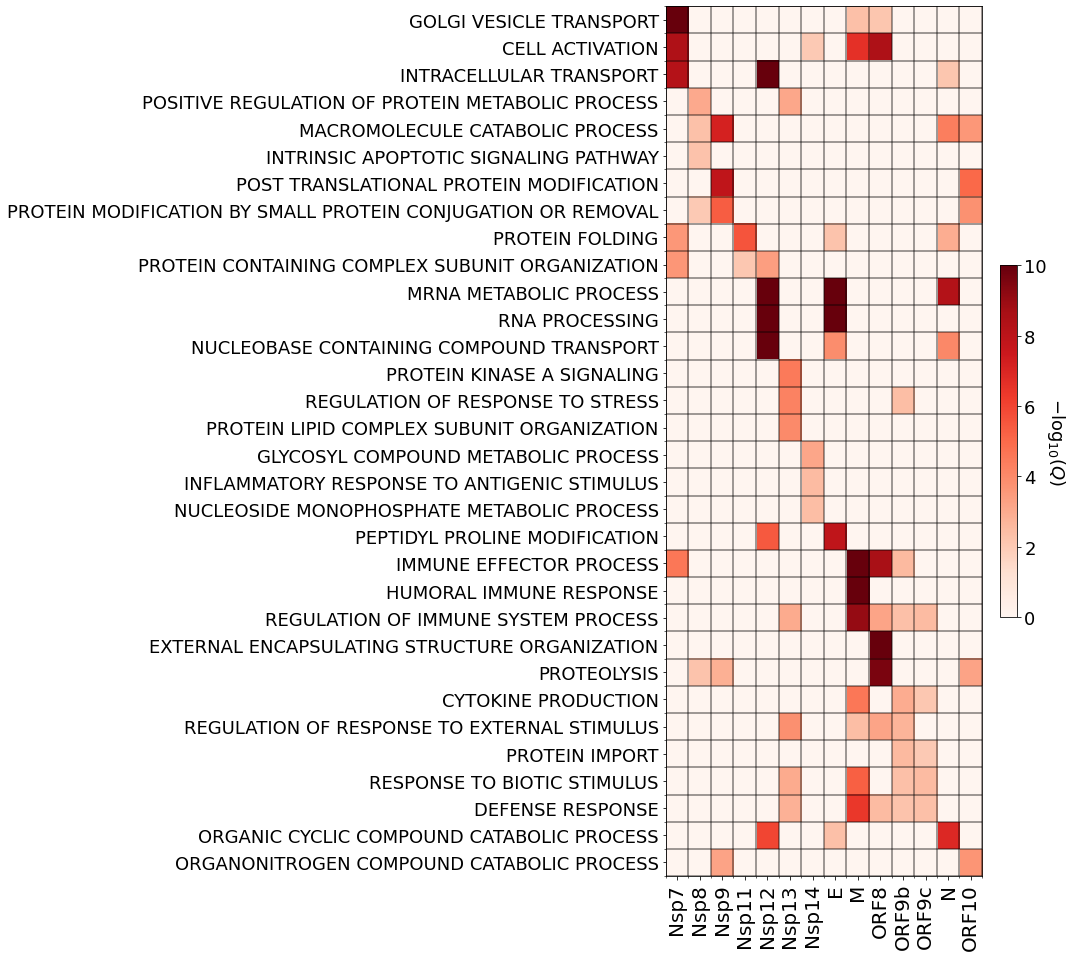

In [24]:
fig, ax = plt.subplots(figsize=(w,l))

#plt.imshow(total_q,cmap=cm.gist_heat_r,aspect='auto',vmin=-math.log10(cutoff),vmax=c_max)
#plt.imshow(total_q,cmap=cm.Greens,aspect='auto',vmin=0,vmax=c_max)

plt.imshow(non_zero_q,cmap=cm.Reds,aspect='auto',vmin=0,vmax=c_max)

#plt.imshow(total_q,cmap=cm.coolwarm,aspect='auto',vmin=c_min,vmax=c_max,alpha=0.8)
cbar = plt.colorbar(fraction=0.05,pad=0.05)

#ax.set_xticks(np.arange(0,len(short_sars)))
#ax.set_xticklabels(short_sars,fontsize=20,rotation=90)

ax.set_xticks(np.arange(0,len(non_zero_short_sars)))
ax.set_xticklabels(non_zero_short_sars,fontsize=20,rotation=90)

ax.set_yticks(np.arange(0,len(selected_gos)))
ax.set_yticklabels(selected_gos,fontsize=18)

cbar.set_label(r'$-\log_{10}$($Q$)',fontsize=18,rotation=-90,labelpad=20)
cbar.ax.tick_params(labelsize=18)

# Minor ticks
#ax.set_xticks(np.arange(-.5, len(short_sars), 1), minor=True)
ax.set_xticks(np.arange(-.5, len(non_zero_short_sars), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(selected_gos), 1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='black', linestyle='-', linewidth=1.5, alpha=0.5)

In [25]:
go_tags, go_names, p_values = enGO.compute_p_values(sources,GO_BPs,direct_interaction_set,total_genes)#,size_threshold=gene_set_cutoff)

In [26]:
q_values = {}

for s_g in sources:
    go_tags[s_g], go_names[s_g], q_values[s_g] = enGO.compute_q_values(p_values[s_g],go_names[s_g],go_tags[s_g],0.01)

In [ ]:
cutoff = 0.01

n = 1000000

selected_gos = []

for s in sources:
    n_c = min(n,len(go_names[s]))
    
    for go,q in zip(go_names[s][:n_c],q_values[s][:n_c]):
        if go not in selected_gos and q<cutoff:
            selected_gos.append(go)
            
print(len(selected_gos))

In [27]:
total_q = (-math.log10(1))*np.ones(shape=(len(selected_gos),len(sources)))

for i in range(0,len(selected_gos)):
    for j in range(0,len(sources)):
        s_g = sources[j]
        
        try:
            k = go_names[s_g].index(selected_gos[i])
            
            if q_values[s_g][k]<cutoff:         
                total_q[i,j] = -math.log10(q_values[s_g][k])
            else:
                total_q[i,j] = 0.0
                
        except ValueError:
            pass

short_sars = []

for s in sources:
    short_sars.append(s.split(' ')[1])

In [28]:
c_max = 10#min(np.max(total_q),10.0)
r = c_max + math.log10(cutoff)
c_min = -math.log10(cutoff) - r

print(np.min(total_q))

print(c_max,c_min,r)

-0.0
10 -6.0 8.0


In [29]:
pixel_width = 0.5

l = pixel_width*len(selected_gos)

non_zero_short_sars = []

non_zero_q = np.zeros(shape=total_q.shape)

for i in range(total_q.shape[1]):
    #print(np.sum(total_q[:,i]))
    
    #if np.sum(total_q[:,i])>0.0:
    non_zero_short_sars.append(short_sars[i])

    if np.sum(non_zero_q)==0.0:
        non_zero_q = total_q[:,i]
    else:
        non_zero_q = np.vstack((non_zero_q,total_q[:,i]))
    
print(non_zero_short_sars)

non_zero_q = np.transpose(non_zero_q)

print(non_zero_q.shape,total_q.shape)
w = 0.9*pixel_width*len(non_zero_short_sars)

['Nsp2', 'Nsp5', 'Nsp7', 'Nsp8', 'Nsp9', 'Nsp10', 'Nsp11', 'Nsp12', 'Nsp13', 'Nsp14', 'Nsp15', 'Spike', 'ORF3a', 'E', 'M', 'ORF8', 'ORF9b', 'ORF9c', 'N', 'ORF10']
(32, 18) (32, 20)


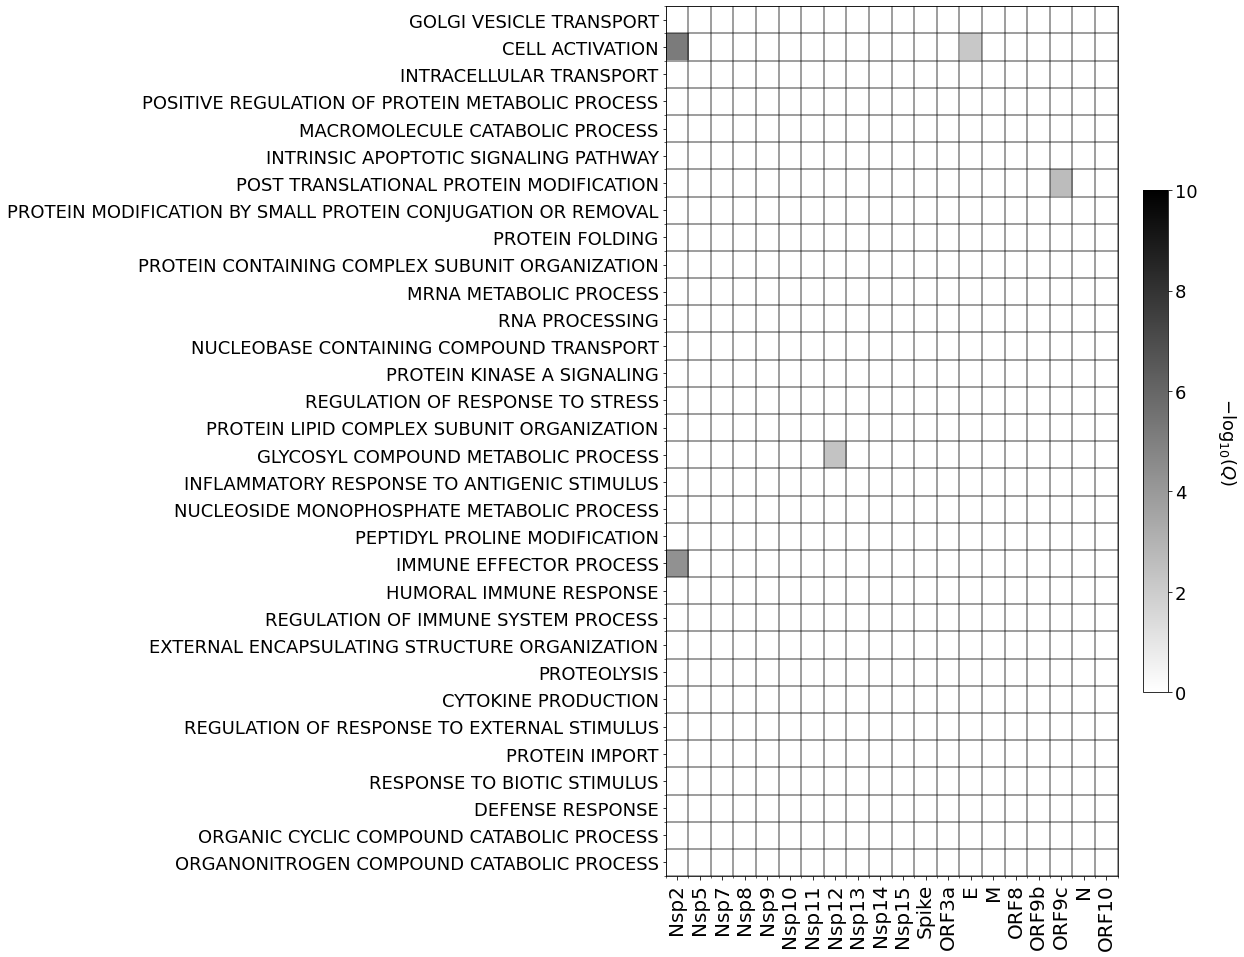

In [30]:
fig, ax = plt.subplots(figsize=(w,l))

#plt.imshow(total_q,cmap=cm.binary,aspect='auto',vmin=0.0,vmax=c_max)

plt.imshow(non_zero_q,cmap=cm.binary,aspect='auto',vmin=0,vmax=c_max)

cbar = plt.colorbar(fraction=0.05,pad=0.05)

ax.set_xticks(np.arange(0,len(non_zero_short_sars)))
ax.set_xticklabels(non_zero_short_sars,fontsize=20,rotation=90)

#ax.set_xticks(np.arange(0,len(short_sars)))
#ax.set_xticklabels(short_sars,fontsize=20,rotation=90)

ax.set_yticks(np.arange(0,len(selected_gos)))
ax.set_yticklabels(selected_gos,fontsize=18)

cbar.set_label(r'$-\log_{10}$($Q$)',fontsize=18,rotation=-90,labelpad=40)
cbar.ax.tick_params(labelsize=18)

# Minor ticks
#ax.set_xticks(np.arange(-.5, len(short_sars), 1), minor=True)
ax.set_xticks(np.arange(-.5, len(non_zero_short_sars), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(selected_gos), 1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='black', linestyle='-', linewidth=1.5, alpha=0.5)

In [ ]:
wf = open(state_type+'-selected_gos-hierarchical.csv','w')

for s in selected_gos:
    print(s,file=wf)
    
wf.close()